# Assignment 2: Convolutional Neural Networks
Instructions: In Assignment 2, you will learn all about the convolutional neural networks. In particular, you will gain a first-hand experience of the training process, understand the architectural details, and familiarize with transfer learning
with deep networks.

## Part 1: Convolutional Neural Networks
In this part, you will experiment with a convolutional neural network implementation to perform image classification. The dataset we will use for this assignment was created by Zoya Bylinskii, and contains 451 works of art from 11 different artists all downsampled and padded to the same size. The task is to identify which artist produced each image. The original images can be found in the `art_data/artists` directory included with the data zip file. The composition of the dataset and a sample painting from each artist are shown in Table 1.

Figure 1 shows an example of the type of convolutional architecture typically employed for similar image recognition problems. Convolutional layers apply filters to the image, and produce layers of
feature maps. Often, the convolutional layers are interspersed with pooling layers. The final layers of the network are fully connected, and lead to an output layer with one node for each of the K classes
the network is trying to detect. We will use a similar architecture for our network.

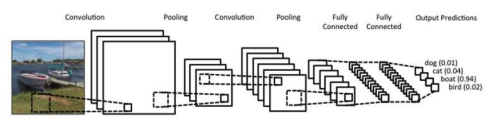

The code for performing the data processing and training the network is provided in the starter
pack. You will use PyTorch to implement convolutional neural networks. We create a dataset from the artists’ images by downsampling them to 50x50 pixels, and transforming the RGB values to lie within the range $[-0.5, 0.5]$. We provide a lot of starter code below, but you will need to modify the hyperparameters and network structure.

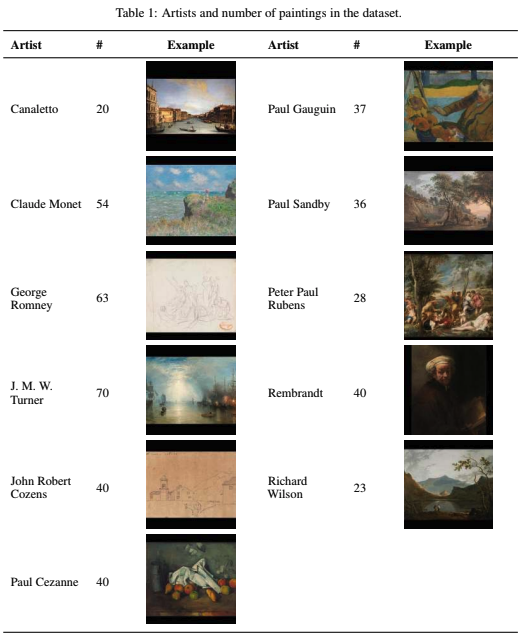

### Part 1.1: Convolutional Filter Receptive Field

First, it is important to develop an intuition for how a convolutional layer affects the feature representations that the network learns. Assume that you have a network in which the first convolutional layer
applies a 5x5 patch to the image, producing a feature map $Z_{1}$. The next layer of the network is also convolutional; in this case, a 3x3 patch is applied to the feature map $Z_{1}$ to produce a new feature
map, $Z_{2}$. Assume the stride used in both cases is 1. Let the receptive field of a node in this network be the portion of the original image that contributes information to the node (that it can, through the filters of the network, “see”). What are the dimensions of the receptive field for a node in $Z_{2}$? Note that you can ignore padding, and just consider patches in the middle of the image and $Z_{1}$. Thinking about your answer, why is it effective to build convolutional networks deeper, i.e. with more layers?

<font color='red'>Answer here: </font>

### Part 1.2: Run the PyTorch ConvNet

Study the provided SimpleCNN class below, and take a look at the hyperparameters. Answer the following questions about the initial implementation:

1) How many layers are there? Are they all convolutional? If not, what structure do they have?
2) Which activation function is used on the hidden nodes?
3) What loss function is being used to train the network?
4) How is the loss being minimized?

<font color='red'> Answer here: </font>

Now that you are familiar with the code, try training the network. It should take between 60-120 seconds to train for 50 epochs. What is the training accuracy for your network after training? What is the validation accuracy? What do these two numbers tell you about what your network is doing?

<font color='red'>Answer here: </font>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image, ImageFile
import tqdm
from torch.nn import CrossEntropyLoss
import time
import random
from torchvision import transforms, utils
import numpy as np
import os
from torch import optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling= False):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        if pooling:
            self.fully_connected_layer = nn.Linear(64,64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.final_layer(x)
        return x

In [ ]:
class LoaderClass(Dataset):
    def __init__(self,data,labels,phase,transforms):
        super(LoaderClass, self).__init__()
        self.transforms = transforms
        self.labels = labels[phase + "_labels"]
        self.data = data[phase + "_data"]
        self.phase = phase

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.data[idx]
        img = Image.fromarray(img)
        img = self.transforms(img)
        return img,torch.from_numpy(label)

In [ ]:
class Trainer():
    def __init__(self,model,criterion,tr_loader,val_loader,optimizer,
                 num_epoch,patience,batch_size,lr_scheduler=None):
        self.model = model
        self.tr_loader = tr_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.num_epoch = num_epoch
        self.patience = patience
        self.lr_scheduler = lr_scheduler
        self.criterion = criterion
        self.softmax = nn.Softmax()
        self.no_inc = 0
        self.best_loss = 9999
        self.phases = ["train","val"]
        self.best_model = []
        self.best_val_acc = 0
        self.best_train_acc = 0
        self.best_val_loss = 0
        self.best_train_loss = 0
        self.batch_size = batch_size

        pass
    def train(self):
        pbar = tqdm.tqdm(desc= "Epoch 0, phase: Train",postfix="train_loss : ?, train_acc: ?")
        for i in range(self.num_epoch):
            last_train_acc = 0
            last_val_acc = 0
            last_val_loss = 0
            last_train_loss = 0
            pbar.update(1)

            for phase in self.phases:
                total_acc = 0
                total_loss = 0
                start = time.time()
                if phase == "train":
                    pbar.set_description_str("Epoch %d,"% i + "phase: Training")
                    loader = self.tr_loader
                    self.model.train()
                else:
                    pbar.set_description_str("Epoch %d,"% i + "phase: Validation")
                    loader = self.val_loader
                    self.model.eval()
                iter = 0
                for images,labels in loader:
                    iter += 1
                    images = images.to(self.model.device)
                    labels = labels.to(self.model.device)
                    self.optimizer.zero_grad()
                    logits = self.model(images)
                    softmaxed_scores = self.softmax(logits)
                    _, predictions = torch.max(softmaxed_scores,1)
                    _, labels = torch.max(labels,1)
                    loss = self.criterion(softmaxed_scores.float(),labels.long())
                    total_loss += loss.item()
                    total_acc += torch.sum(predictions == labels).item()

                    if phase == "train":
                        pbar.set_postfix_str("train acc: %6.3f," %(total_acc/ (iter*self.batch_size)) + ("train loss: %6.3f" % (total_loss / iter)))
                        loss.backward()
                        self.optimizer.step()
                    else:
                        pbar.set_postfix_str("val acc: %6.3f," %(total_acc/ (iter*self.batch_size)) + ("val loss: %6.3f" % (total_loss / iter)))


                if phase == "train":
                    if self.lr_scheduler:

                        self.lr_scheduler.step()
                end = time.time()
                if phase == "train":
                    loss_p = total_loss / iter
                    acc_p = total_acc / len(self.tr_loader.dataset)
                    last_train_acc = acc_p
                    last_train_loss = loss_p
                else:
                    loss_p = total_loss / iter
                    acc_p = total_acc / len(self.val_loader.dataset)
                    last_val_acc = acc_p
                    last_val_loss = loss_p

                    if loss_p < self.best_loss:
                        print("New best loss, loss is: ",str(loss_p), "acc is: ",acc_p )
                        self.best_loss = loss_p
                        self.no_inc = 0
                        self.best_model = self.model
                        self.best_train_acc = last_train_acc
                        self.best_train_loss = last_train_loss
                        self.best_val_loss = last_val_loss
                        self.best_val_acc = last_val_acc
                    else:
                        print("Not a better score")


                        self.no_inc += 1
                        if self.no_inc == self.patience:
                            print("Out of patience returning the best model")
                            print(
                                "Best val acc: {}, Best val loss: {}, Best train acc: {}, Best train loss: {} ".format(
                                    self.best_val_acc, self.best_val_loss, self.best_train_acc, self.best_train_loss
                                ))  # Stats of the best model
                            return self.best_model
        print("Training ended returning the best model")
        print(
            "Best val acc: {}, Best val loss: {}, Best train acc: {}, Best train loss: {} ".format(
                self.best_val_acc, self.best_val_loss, self.best_train_acc, self.best_train_loss
            ))  # Stats of the best model
        return self.best_model

In [ ]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = False
NUM_EPOCHS = 200
PATIENCE = -1
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
def load_artist_data():
    data = []
    labels = []
    artists = [x for x in os.listdir(DATA_PATH) if x != '.DS_Store']
    print(artists)
    for folder in os.listdir(DATA_PATH):
        class_index = artists.index(folder)
        for image_name in os.listdir(DATA_PATH + "/" + folder):
            img = Image.open(DATA_PATH + "/" + folder + "/" + image_name)
            artist_label = (np.arange(NUM_ARTISTS) == class_index).astype(np.float32)
            data.append(np.array(img))
            labels.append(artist_label)
    shuffler = np.random.permutation(len(labels))
    data = np.array(data)[shuffler]
    labels = np.array(labels)[shuffler]

    length = len(data)
    val_size = int(length*0.2)
    val_data = data[0:val_size+1]
    train_data = data[val_size+1::]
    val_labels = labels[0:val_size+1]
    train_labels = labels[val_size+1::]
    print(val_labels)
    data_dict = {"train_data":train_data,"val_data":val_data}
    label_dict = {"train_labels":np.array(train_labels),"val_labels":np.array(val_labels)}

    return data_dict,label_dict

In [ ]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=False)
optimizer = optim.Adam(model.parameters(), lr=LR)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

In [ ]:
train_dataset = LoaderClass(data,labels,"train",transform["train"])
valid_dataset = LoaderClass(data,labels,"val",transform["val"])
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=0, pin_memory=True)


In [ ]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE,batch_size=BATCH_SIZE,lr_scheduler= None)
best_model = trainer_m.train()

### Part 1.3: Add Pooling Layers
We will now add max pooling layers after each of our convolutional layers. This code has already been provided for you; all you need to do is switch the pooling flag in the hyper-parameters to True,
and choose different values for the pooling filter size and stride. After you applied max pooling, what happened to your results? How did the training accuracy vs. validation accuracy change? What does
that tell you about the effect of max pooling on your network?

<font color='red'>Answer here: </font>

### Part 1.4: Regularize Your Network!
Because this is such a small dataset, your network is likely to overfit the data. Implement the following ways of regularizing your network. Test each one individually, and discuss how it affects your results.

- __Dropout__: In PyTorch, this is implemented using the `torch.nn.dropout` class, which takes a value called the `keep_prob`, representing the probability that an activation will be dropped out. This value should be between 0.1 and 0.5 during training, and 0 for evaluation and testing. An example of how this works is available here. You should add this to your network and try different values to find one that works well.

- __Weight Regularization__: You should try different optimizers, and different weight decay values for optimizers.

- __Early Stopping__: Stop training your model after your validation accuracy starts to plateau or decrease (so you do not overtrain your model). The number of steps can be controlled through the `patience` hyperparameter in the code.

- __Learning Rate Scheduling__: Learning rate scheduling is an important part of training neural networks. There are a lot of techniques for learning rate scheduling. You should try
different schedulers such as `StepLR`, `CosineAnnealing`, etc.

Give your results for each of these regularization techniques, and discuss which ones were the most effective.

<font color='red'>Answer here: </font>

### Part 1.5: Experiment with Your Architecture

All those parameters at the top of `SimpleCNN` still need to be set. You cannot possibly explore all combinations; so try to change some of them individually to get some feeling for their effect (if any).
Optionally, you can explore adding more layers. Report which changes led to the biggest increases and decreases in performance. In particular, what is the effect of making the convolutional layers have (a) a larger filter size, (b) a larger stride and (c) greater depth? How does a pyramidal-shaped network in which the feature maps gradually decrease in height and width but increase in depth compare to a flat architecture, or one with the opposite shape?

<font color='red'>Answer here: </font>

### Part 1.6: Optimize Your Architecture
Based on your experience with these tests, try to achieve the best performance that you can on the validation set by varying the hyperparameters, architecture, and regularization methods. You can even (optionally) try to think of additional ways to augment the data, or experiment with techniques like local response normalization layers using `torch.nn.LocalResponseNorm` or weight normalization using the implementation [here](https://pytorch.org/docs/stable/_modules/torch/nn/utils/weight_norm.html#weight_norm). Report the best performance you are able to achieve, and the settings you used to obtain it.

<font color='red'>Answer here: </font>

### Part 1.7: Test Your Final Architecture on Variations of the Data
In PyTorch data augmentation can be done dynamically while loading the data using what they call `transforms`. Note that some of the transforms are already implemented. You can
try other transformations, such as the ones shown in Figure 3 and also try different probabilities for these transformations. You may find [this link](https://pytorch.org/vision/stable/transforms.html) helpful. Note that the PyTorch data loader refreshes the
data in each epoch and apply different transformations to the different instances.

Now that you have optimized your architecture, you are ready to test it on augmented data!
Report your performance on each of the transformed datasets. Are you surprised by any of the results?
Which transformations is your network most invariant to, and which lead it to be unable to recognize the images? What does that tell you about what features your network has learned to use to recognize artists’ images?

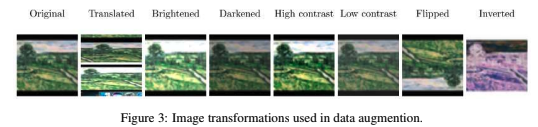

## Part 2: Transfer Learning with Deep Network

In this part, you will fine-tune AlexNet model pretrained on ImageNet to recognize faces. For the sake of simplicity you may use [the pretrained AlexNet model](https://pytorch.org/hub/pytorch_vision_alexnet/) provided in PyTorch Hub. You will
work with a subset of the FaceScrub dataset. The subset of male actors is [here](http://www.cs.toronto.edu/~guerzhoy/321/proj1/subset_actors.txt) and the subset of female actors is [here](http://www.cs.toronto.edu/~guerzhoy/321/proj1/subset_actresses.txt). The dataset consists of URLs of images with faces, as well as the bounding boxes of the faces. The format of the bounding box is as follows (from the FaceScrub `readme.txt` file):

`
The format is x1,y1,x2,y2, where (x1,y1) is the coordinate of the top-left corner of the bounding box and (x2,y2) is that of the bottom-right corner, with (0,0) as the top-left corner of the image. Assuming the image is represented as a Python NumPy array I, a face
in I can be obtained as I[y1:y2, x1:x2].
`

You may find it helpful to use and/or modify [this script](www.cs.toronto.edu/~guerzhoy/321/proj1/get_data.py) for downloading the image data. Note that you should crop out the images of the faces and resize them to appropriate size before proceeding further. Make sure to check the SHA-256 hashes, and make sure to only keep faces for which the hashes match. You should set aside 70 images per faces for the training set, and use the rest for the test and validation set.

### Part 2.1: Train a Multilayer Perceptron
First resize the images to 28 × 28 pixels. Use a fully-connected neural network with a single hidden layer of size 300 units.
Below, include the learning curve for the test, training, and validation sets, and the final performance classification on the test set. Include a text description of your system. In particular, describe how you preprocessed the input and initialized the weights, what activation function you used, and what the exact architecture of the network that you selected was. You might get performances close to 80-85% accuracy rate.

### Part 2.2: AlexNet as a Fixed Feature Extractor
Extract the values of the activations of AlexNet on the face images. Use those as features in order to perform face classification: learn a fully-connected neural network that takes in the activations of the units in the AlexNet layer as inputs, and outputs the name of the person. Below, include a description of the system you built and its performance. It is recommended to start out with only using the `conv4` activations. Using `conv4` is sufficient here.

### Part 2.3: Visualize Weights
Train two networks the way you did in Part 2.1. Use 300 and 800 hidden units in the hidden layer. Visualize 2 different hidden features (neurons) for each of the two settings, and briefly explain why they are interesting. A sample visualization of a hidden feature is shown below. Note that you probably need to use L2 regularization while training to obtain nice weight visualizations.

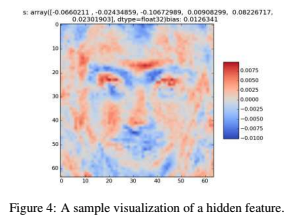

### Part 2.4: Finetuning AlexNet
Train two networks the way you did in Part 2.1. Use 300 and 800 hidden units in the hidden layer. Visualize 2 different hidden features (neurons) for each of the two settings, and briefly explain why they are interesting. A sample visualization of a hidden feature is shown in Figure 4. Note that you probably need to use L2 regularization while training to obtain nice weight visualizations.

### Part 2.5: Bonus: Gradient Visualization
Here, you will use [Utku Ozbulak’s PyTorch CNN Visualizations Library](https://github.com/utkuozbulak/pytorch-cnn-visualizations/) to visualize the important parts of the input image for a particular output class. In particular, just select a specific picture of an actor, and then using your trained network in Part 2.4, perform Gradient visualization with guided backpropagation to understand the prediction for that actor with respect to the input image. Comment on your results.

## What to Turn In
You have two **options** for submission:
1) Provide all the relevant answers to questions, images, figures, etc, in this Jupyter notebook, convert the jupyter notebook into a PDF, and upload the PDF.
2) Write all the answers to the questions and any relevant figures in a LaTeX report, convert the report to a PDF, and upload a zip file containing both the jupyter notebook and the report.

## Grading
The assignment will be graded out of `100` points: `0` (no submission), `20` (an attempt at a solution), `40` (a partially correct solution), `60` (a mostly correct solution), `80` (a correct solution), `100` (a correct solution with lots of detail and analysis). The grading depends on both the content and clarity of your report.